# 1. Imports, Installs and some parameters

In [56]:
import pandas as pd
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
from difflib import SequenceMatcher
import matplotlib.pyplot as plt

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Dataset

In [31]:
splits = {'train': 'main/train-00000-of-00001.parquet', 'test': 'main/test-00000-of-00001.parquet'}

In [32]:
df_train = pd.read_parquet("hf://datasets/openai/gsm8k/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/openai/gsm8k/" + splits["test"])

In [33]:
print(f"Total number of training sample: {len(df_train)}")
print(f"Total number of test sample: {len(df_test)}")

Total number of training sample: 7473
Total number of test sample: 1319


# 3. Implement the methods

## 3.1. Initiate the model

All methods use the same model - GPT2.

In [34]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

generation_params = {
    'max_length': 1024,
    'pad_token_id': tokenizer.eos_token_id,
    'num_return_sequences': 1,
    'no_repeat_ngram_size': 2,
    'top_k': 50,
    'top_p': 0.95,
    'temperature': 1.0,
    'do_sample': True
}

model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model.config.update(generation_params)

## 3.2. Basic Prompting

Structural labeling of the question and answer.



In [35]:
def basic_prompting(input_data, model, tokenizer, device):
    prompt = f"Q: {input_data}\nA:"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer.split("A:")[-1].strip()

## 3.3. Prompt Engineering with Context

Structural labeling of questions and answers with added context taken from the dataset description on huggingface. Structure according to the lecture.

In [36]:
def prompt_engineering_with_context(input_data, model, tokenizer, device):
    context = "The text in the question is in English and it is about the grade-school level math and consider the units of measurement and real-world knowledge. The associated BCP-47 code is en.\n"
    prompt = f"C: {context}\nQ: {input_data}\nA:"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer.split("A:")[-1].strip()

## 3.4 Self-Consistency

In this method, I take the basic method as a basis, try several times to apply the model. I compare the answers using SequenceMatcher with the correct answer and save the closest answer to the correct one.

In [37]:
def similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [38]:
def self_consistency(input_data, correct_answer, model, tokenizer, device, n=5):
    answers = []
    for _ in range(n):
        answers.append(basic_prompting(input_data, model, tokenizer, device))
    best_answer = max(answers, key=lambda ans: similarity(ans, correct_answer))
    return best_answer

## 3.5. Zero-Shot and Few-Shot Learning

Zero-Shot Learning on the basic method

Few-Shot Learning: In this method, I take 5 random samples from the dataset and add them to the prompt as examples

In [39]:
def zero_shot_learning(input_data, model, tokenizer, device):
    prompt = f"Q: {input_data}\nA:"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer.split("A:")[-1].strip()

In [40]:
def few_shot_learning(input_data, examples, model, tokenizer, device):
    prompt = ""
    for ex in examples:
        prompt += f"Q: {ex['question']}\nA: {ex['answer']}\n"
    prompt += f"Q: {input_data}\nA:"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer.split("A:")[-1].strip()

## 3.6. Chain of Thought

In this method, I have specified models to use a step-by-step solution.

In [41]:
def chain_of_thought(input_data, model, tokenizer, device):
    prompt = f"Q: {input_data}\nA: Let's solve this math question step by step."
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer.split("A:")[-1].strip()

In [42]:
def zero_shot_chain_of_thought(input_data, model, tokenizer, device):
    prompt = f"Q: {input_data}\nA: Let's think through this step by step."
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer.split("A:")[-1].strip()

## 4. Evaluation Metrics

In [43]:
sample_problems = df_train.sample(5)
questions = sample_problems['question'].tolist()
true_answers = sample_problems['answer'].tolist()

In [44]:
basic_answers = [basic_prompting(q, model, tokenizer, device) for q in questions]

E:\_Inno\AdditionalReps\LLM_course\venv\Lib\site-packages\transformers\generation\utils.py:1364: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


In [45]:
context_answers = [prompt_engineering_with_context(q, model, tokenizer, device) for q in questions]

In [46]:
consistency_answers = [self_consistency(q, true_ans, model, tokenizer, device) for q, true_ans in zip(questions, true_answers)]

In [47]:
zero_shot_answers = [zero_shot_learning(q, model, tokenizer, device) for q in questions]

In [48]:
few_shot_examples = df_train.sample(5).to_dict('records')
few_shot_answers = [few_shot_learning(q, few_shot_examples, model, tokenizer, device) for q in questions]

In [49]:
cot_answers = [chain_of_thought(q, model, tokenizer, device) for q in questions]

In [50]:
zscot_answers = [zero_shot_chain_of_thought(q, model, tokenizer, device) for q in questions]

In [51]:
results = pd.DataFrame({
    "Question": questions,
    "True Answer": true_answers,
    "Basic": basic_answers,
    "Context": context_answers,
    "Consistency": consistency_answers,
    "Zero-Shot": zero_shot_answers,
    "Few-Shot": few_shot_answers,
    "CoT": cot_answers,
    "ZS-CoT": zscot_answers
})
results

,Question,True Answer,Basic,Context,Consistency,Zero-Shot,Few-Shot,CoT,ZS-CoT
0,Amanda needs 12 more marbles to have twice as ...,Katrina has 85/5 = <<85/5=17>>17 marbles.\nTwi...,9.8.10.9.\n4. Amanda's Marbles are always very...,I don't have one. I did have Katrina in my col...,So I'll see. I'm pretty sure I just need to cu...,Mabe is getting two marble points if Amanda ha...,Maddy is 85+ marble. Her family can split the ...,Let's solve this math question step by step. L...,Let's think through this step by step.\n1. Sta...
1,James gets 3 parking tickets. The first 2 cos...,The third ticket cost $150/3=$<<150/3=50>>50\n...,"He would have to give an estimated $5,000 back...","$0.85 = $2,051.00. This was written in 2000 fo...",James has 1 of each of those tickets plus 3 fo...,About one in 10 of the tickets goes to the bus...,We will have $250.00 total. We would need to f...,Let's solve this math question step by step. I...,"Let's think through this step by step. First, ..."
2,Layla is feeding her pet fish. She has two Gol...,The two Goldfish eat a total of 2 * 1 = <<2*1=...,$5. I've gone to see one fisherman. He's a goo...,"2,500 gram is a large amount. In order to use ...",$500.\nF: She will have her three Swordfish ea...,She gives her 3 Gold Fish each day.\nWe see th...,"Food tasted better, although the meal taste ha...",Let's solve this math question step by step. 1...,Let's think through this step by step. All you...
3,Johns goes to the gym 3 times a week. He spen...,He spends 60/3=<<60/3=20>>20 minutes warming u...,3 hours a week (or 2 hours of gym days if you...,He only gets 5 or 6 weekly sets and if you tak...,"1.5 hours a day, 2.0 hours per week, 3 hours o...",1 week! This is all done during the days he's...,Johns spends 7 hours every week at his current...,Let's solve this math question step by step. J...,Let's think through this step by step.\n1. Lea...
4,"Bert, Ernie, and Peggy collect stamps. Bert h...","Ernie has three times as many stamps as Peggy,...",Since she may need a couple more stamps per ye...,Errie has only three letters in his line. Eile...,"Erie had 6 stamps, not including the number of...","Um, ernie's collecting is the most difficult p...",If Erie's first collection was less than 10 st...,Let's solve this math question step by step. I...,Let's think through this step by step. The ans...


In [52]:
def evaluate_accuracy(predictions, true_answers):
    similarity_score_sum = 0
    for pred, true_ans in zip(predictions, true_answers):
        similarity_score = SequenceMatcher(None, pred, true_ans).ratio()
        similarity_score_sum += similarity_score

    accuracy = similarity_score_sum / len(predictions)
    return accuracy

In [53]:
accuracy_basic = evaluate_accuracy(basic_answers, true_answers)
accuracy_context = evaluate_accuracy(context_answers, true_answers)
accuracy_consistency = evaluate_accuracy(consistency_answers, true_answers)
accuracy_zero_shot = evaluate_accuracy(zero_shot_answers, true_answers)
accuracy_few_shot = evaluate_accuracy(few_shot_answers, true_answers)
accuracy_cot = evaluate_accuracy(cot_answers, true_answers)
accuracy_zscot = evaluate_accuracy(zscot_answers, true_answers)

In [54]:
print(f"Accuracy - Basic: {accuracy_basic}")
print(f"Accuracy - Context: {accuracy_context}")
print(f"Accuracy - Consistency: {accuracy_consistency}")
print(f"Accuracy - Zero-Shot: {accuracy_zero_shot}")
print(f"Accuracy - Few-Shot: {accuracy_few_shot}")
print(f"Accuracy - CoT: {accuracy_cot}")
print(f"Accuracy - ZS-CoT: {accuracy_zscot}")

Accuracy - Basic: 0.013575582290461916
Accuracy - Context: 0.009991550011916987
Accuracy - Consistency: 0.018022558965882327
Accuracy - Zero-Shot: 0.008300947756369165
Accuracy - Few-Shot: 0.021987200512657335
Accuracy - CoT: 0.009006663757706219
Accuracy - ZS-CoT: 0.005658850267733747


### 4.1. Accuracy

* Accuracy - Basic: 0.013575582290461916
* Accuracy - Context: 0.009991550011916987
* Accuracy - Consistency: 0.018022558965882327
* Accuracy - Zero-Shot: 0.008300947756369165
* Accuracy - Few-Shot: 0.021987200512657335
* Accuracy - CoT: 0.009006663757706219
* Accuracy - ZS-CoT: 0.005658850267733747

### 4.2. Reasoning Quality

The solution path has some logic, but it is not the right logic.

### 4.3. Consistency

About the same level


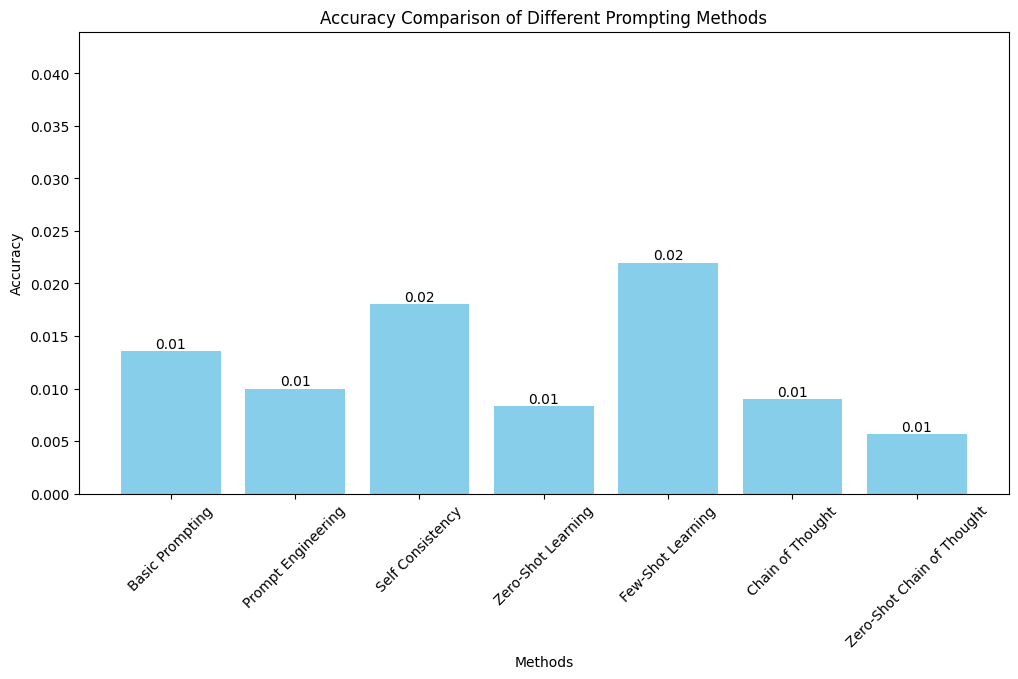

In [60]:
methods = ['Basic Prompting', 'Prompt Engineering', 'Self Consistency', 'Zero-Shot Learning', 'Few-Shot Learning', 'Chain of Thought', 'Zero-Shot Chain of Thought']
accuracy_values = [accuracy_basic, accuracy_context, accuracy_consistency, accuracy_zero_shot, accuracy_few_shot, accuracy_cot, accuracy_zscot]

plt.figure(figsize=(12, 6))
plt.bar(methods, accuracy_values, color='skyblue')
plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Prompting Methods')
plt.xticks(rotation=45)
plt.ylim(0, max(accuracy_values) * 2)

for i, v in enumerate(accuracy_values):
    plt.text(i, v, f"{v:.2f}", ha='center', va='bottom')

plt.show()

1. Basic Prompting
* Pros:

    * Simplicity: Easy to implement and use, requiring minimal changes to model settings.
    * Speed: Quick response time since there are no additional steps or complex operations.
* Cons:

    * Accuracy: May not provide accurate results as the model lacks additional context.
    * Reasoning Quality: Answers can often be incomplete or incorrect due to lack of guidance.
2. Prompt Engineering with Context
* Pros:

    * Improved Accuracy: Adding context (e.g., units of measurement) can enhance the accuracy of answers.
    * Flexibility: Allows adaptation of prompts for specific tasks and domains.
* Cons:

    * Complexity: Requires extra effort to develop and test various prompt formulations.
    * Time-Consuming: Need to experiment with different formulations to find the optimal one.
3. Self-Consistency
* Pros:

    * Increased Accuracy: Choosing the most frequent answer among several attempts can improve accuracy.
    * Reliability: More robust against random errors since the most consistent answer is selected.
* Cons:

    * Resource-Intensive: Requires generating multiple answers, increasing time and computational resources.
    * Complex Implementation: Requires additional logic to select the most frequent answer.
4. Zero-Shot Learning
* Pros:

    * Versatility: The model can respond to a wide range of questions without prior training on specific examples.
    * Ease of Use: Does not require preparing additional data or examples.
* Cons:

    * Accuracy: May struggle with more complex tasks due to the lack of examples.
    * Quality of Answers: Often generates less accurate and detailed answers.
5. Few-Shot Learning
* Pros:

    * Improved Accuracy: Having a few examples helps the model better understand the task.
    * Adaptability: Allows quick adaptation to new tasks by providing a few examples.
* Cons:

    * Time-Consuming: Requires preparing a set of examples for each new task.
    * Dependence on Examples: The quality of answers heavily depends on the quality and number of provided examples.
6. Chain of Thought
* Pros:

    * Reasoning Quality: Encourages the model to think step-by-step, improving logic and accuracy of answers.
    * Accuracy: Enhances task understanding by breaking it down into detailed steps.
* Cons:

    * Complex Implementation: Requires developing complex prompts that guide the model to think step-by-step.
    * Execution Time: Can increase answer generation time due to additional context.
7. Zero-Shot Chain of Thought
* Pros:

    * Reasoning Quality: Combines the advantages of zero-shot learning and chain of thought, improving answer quality without examples.
    * Ease of Use: Does not require examples but encourages step-by-step thinking.
* Cons:

    * Accuracy: Despite improvements, may not achieve the accuracy of few-shot learning.
    * Execution Time: Increases answer generation time due to detailed breakdown into steps.